# Truncation variants

This Jupyter notebook reproduces various panels from Figure 5, which studies the insertion/expression patterns in the four mutually exclusive candidate genes (*MYH9*, *TP53BP2*, *PPP1R12A* and *PPP1R12B*) to determine how these genes are affected by their insertions.

In [2]:
%reload_ext autoreload

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

## Insertion patterns

To get an idea of how insertions are distributed across the different genes, we want to visualize the insertions together with the trancript annotation of these genes. To do so, we use a Python package called **geneviz**, which we developed to provide a structured visualization framework for plotting data along genomic coordinates.

Geneviz plots genomic data and annotations as tracks along a genomic axis, similar to many approaches used by many genome browsers. For the insertion plots, we use three tracks: an insertion (feature) track, an insertion density track and a gene annotation track. The insertion feature track displays insertions as arrows, with the position/direction of the arrow indicating the location/orientation (forward/reverse strand) of the insertion and the color indicating whether the insertion is in sense with the gene (blue) or in an antisense orientation (red). The density track provides a more accurate overview of the exact location of insertions with respect to the gene annotation. The gene annotation shows the structure of the corresponding gene transcript.

For each gene we select a single transcript as its 'canonical' transcript. This is typically chosen as the longest CCDS transcript for the gene (as indicated by Ensembl). The same transcripts will be used later on in the exon expression analyses.

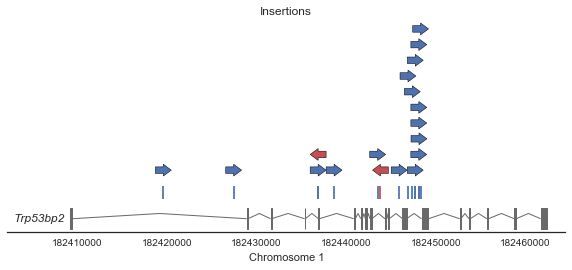

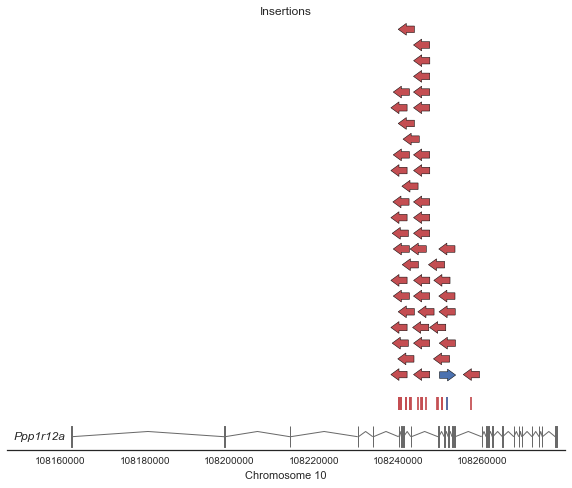

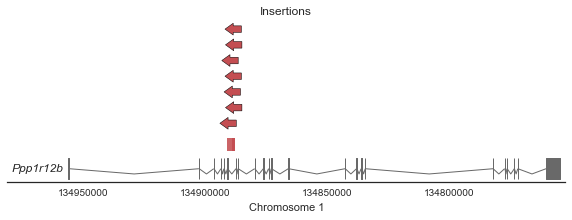

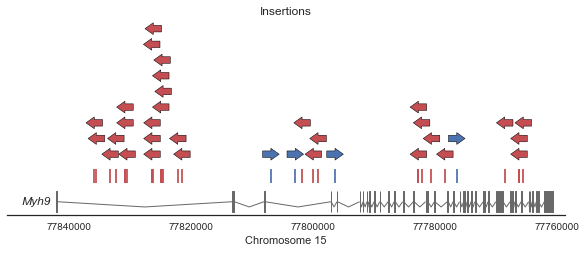

In [4]:
from nbsupport.insertions import plot_insertion_track, annotate_with_clonality

# Read insertions.
ins_path = ('../data/processed/sb/shear_splink/all/insertions.cis.rbm.txt')
insertions = (pd.read_csv(ins_path, sep='\t')
                .dropna(subset=['gene_name'])
                .pipe(annotate_with_clonality))

# Plot tracks for gene transcripts.
# Ppp1r12a ENSMUSG00000019907 ENSMUST00000070663
# Ppp1r12b ENSMUSG00000073557 ENSMUST00000045665
# Trp53bp2 ENSMUSG00000026510 ENSMUST00000117245
# Myh9     ENSMUSG00000022443 ENSMUST00000016771

shared_kws = {
    'figsize': (10, None),
    'ins_ratio': 1 / 30
}

# Myh9
plot_insertion_track(
    insertions, region=('15', 77760587, 77842175),
    transcript_id='ENSMUST00000016771', padding=(8000, 2000),
    reverse=True, **shared_kws)

# Trp53bp2
plot_insertion_track(
    insertions, region=('1', 182409172, 182462432),
    transcript_id='ENSMUST00000117245', padding=(7000, 2000), 
    reverse=False, **shared_kws);

# Ppp1r12a
plot_insertion_track(
    insertions, region=('10', 108162400, 108277575),
    transcript_id='ENSMUST00000070663', padding=(15000, 2000),
    reverse=False, **shared_kws);

# Ppp1r12b
plot_insertion_track(
    insertions, region=('1', 134754658, 134955942),
    transcript_id='ENSMUST00000045665', padding=(25000, 2000),
    reverse=True, **shared_kws);

with sns.plotting_context('paper', font_scale=0.7):
    # Myh9
    fig = plot_insertion_track(
        insertions, region=('15', 77760587, 77842175),
        transcript_id='ENSMUST00000016771', padding=(8000, 2000),
        reverse=True, figsize=(6, 0.9), ins_ratio=1/55, linewidth=0.3);
    fig.savefig('../reports/figures/fig_5_myh9_ins.pdf', bbox_inches='tight')
    plt.close(fig)
    
    # Ppp1r12a
    fig = plot_insertion_track(
        insertions, region=('10', 108162400, 108277575),
        transcript_id='ENSMUST00000070663', padding=(15000, 2000),
        reverse=False, figsize=(6, 2), ins_ratio=1/55, linewidth=0.3);
    fig.savefig('../reports/figures/fig_5_ppp1r12a_ins.pdf', bbox_inches='tight')
    plt.close(fig)
    
    # Ppp1r12b
    fig = plot_insertion_track(
        insertions, region=('1', 134754658, 134955942),
        transcript_id='ENSMUST00000045665', padding=(25000, 2000),
        reverse=True, figsize=(6, 0.95), ins_ratio=1/55, linewidth=0.3);
    fig.savefig('../reports/figures/fig_5_ppp1r12b_ins.pdf', bbox_inches='tight')
    plt.close(fig)
    
    # Trp53bp2
    fig = plot_insertion_track(
        insertions, region=('1', 182409172, 182462432),
        transcript_id='ENSMUST00000117245', padding=(7000, 2000), 
        reverse=False, figsize=(6, 1.2), ins_ratio=1/55, linewidth=0.3);
    fig.savefig('../reports/figures/fig_5_trp53bp2_ins.pdf', bbox_inches='tight')
    plt.close(fig)

These plots show that *Ppp1r12a/b* and *Trp53bp2* show a tight clustering in their insertions, pointing towards the expression of truncated transcripts. *Myh9* shows a more scattered pattern of insertions, pointing towards general inactivation of the gene. 

## Exon-level expression

To determine if the insertions in *Ppp1r12a/b* and *Trp53bp2* do in fact result in the expression of truncated transcripts, we would like to visualize the relative expression of each genes exons in samples with an insertion in the corresponding gene. If the insertions do result in truncated transcripts, we would expect to see increased expression before/after the insertion site (depending on the orientation of the insertions), supporting the expression of a truncated transcript.

To create such a visualization, we first calculate exon-level expression for each of the transcripts across all samples. We quantify the expression as the average depth of coverage of the exons in each respective sample, in order to avoid biases due to differences in exon sizes.

In [21]:
! python ../scripts/exon_coverage.py \
    --bams `find ../data/interim/sb/rnaseq/bam -name '*.bam'` \
    --gtf ../data/external/ensembl/Mus_musculus.GRCm38.76.gtf.gz \
    --output ../data/processed/sb/rnaseq/exon_coverage.txt \
    --transcript_ids ENSMUST00000070663 ENSMUST00000045665 \
        ENSMUST00000117245 ENSMUST00000016771 \

In [103]:
# Read coverage data.
samples = pd.read_csv('../data/raw/sb/samples.txt', sep='\t')
id_map = dict(zip(samples['rnaseq_id'], samples['sample']))

coverage = (
    pd.read_csv('../data/processed/sb/rnaseq/exon_coverage.txt', 
                sep='\t', index_col=[0, 1, 2, 3, 4])
      .rename(columns=lambda c: c.split('/')[-1].split('.')[0])
      .rename(columns=id_map))

# Map transcripts to genes.
# Ppp1r12a ENSMUSG00000019907 ENSMUST00000070663
# Ppp1r12b ENSMUSG00000073557 ENSMUST00000045665
# Trp53bp2 ENSMUSG00000026510 ENSMUST00000117245
# Myh9     ENSMUSG00000022443 ENSMUST00000016771

transcript_map = {
    'ENSMUST00000070663': 'Ppp1r12a',
    'ENSMUST00000045665': 'Ppp1r12b',
    'ENSMUST00000117245': 'Trp53bp2',
    'ENSMUST00000016771': 'Myh9'
}

coverage = (
    coverage.reset_index()
            .assign(gene=lambda df: df['transcript_id'].map(transcript_map))
            .drop('transcript_id', axis=1)
            .set_index(['gene', 'chr', 'start', 'end', 'strand']))

coverage.head()

11KOU023  12SKA043-R4  \
gene     chr start     end       strand                          
Ppp1r12b 1   134754657 134760495 -       2.231336     2.461822   
             134771997 134772048 -       3.627451     0.000000   
             134773425 134773479 -       2.923077     1.000000   
             134776375 134776480 -       2.022472     1.988506   
             134777314 134777459 -       3.053846     2.064286   

                                         12SKA064-R4-R5  12SKA013-R3  \
gene     chr start     end       strand                                
Ppp1r12b 1   134754657 134760495 -             2.614637     9.701836   
             134771997 134772048 -             2.549020    15.960784   
             134773425 134773479 -             1.000000    12.703704   
             134776375 134776480 -             2.125000     8.066667   
             134777314 134777459 -             1.000000     8.717241   

                                         12SKA134-R3  13SKA017-L4  \
gene     chr start     end       strand                             
Ppp1r12b 1   134754657 134760495 -          8.975253     4.948118   
             134771997 134772048 -          9.450980     2.755556   
             134773425 134773479 -         10.018519     2.574074   
             134776375 134776480 -          6.085714     3.161905   
             134777314 134777459 -          7.917241     3.710345   

                                         12SKA018-L3   11KOU039  12SKA073-R3  \
gene     chr start     end       strand                                        
Ppp1r12b 1   134754657 134760495 -          9.174622   7.161318     2.762463   
             134771997 134772048 -         10.411765  11.333333     0.000000   
             134773425 134773479 -         10.814815   6.092593     0.000000   
             134776375 134776480 -         13.114286   5.552381     0.000000   
             134777314 134777459 -          8.351724   5.117241     0.000000   

                                         12SKA127-R3     ...       \
gene     chr start     end       strand                  ...        
Ppp1r12b 1   134754657 134760495 -          3.121711     ...        
             134771997 134772048 -          1.784314     ...        
             134773425 134773479 -          1.292683     ...        
             134776375 134776480 -          2.980583     ...        
             134777314 134777459 -          1.925926     ...        

                                         12SKA033-R3  12SKA019  11KOU029-R1  \
gene     chr start     end       strand                                       
Ppp1r12b 1   134754657 134760495 -          4.588516  2.593438     2.294756   
             134771997 134772048 -          3.647059  1.000000     4.274510   
             134773425 134773479 -          3.629630  1.000000     1.611111   
             134776375 134776480 -          5.219048  2.000000     1.284314   
             134777314 134777459 -          5.524138  0.000000     1.682540   

                                         12SKA079-R3  12SKA090-L3  \
gene     chr start     end       strand                             
Ppp1r12b 1   134754657 134760495 -          2.378554     4.427169   
             134771997 134772048 -          1.000000     2.705882   
             134773425 134773479 -          1.222222     1.796296   
             134776375 134776480 -          2.828571     4.276190   
             134777314 134777459 -          1.703448     3.600000   

                                         12SKA102-R3  12SKA086-R3   11KOU018  \
gene     chr start     end       strand                                        
Ppp1r12b 1   134754657 134760495 -         10.051852     3.426323   5.598664   
             134771997 134772048 -          7.137255     3.000000  10.039216   
             134773425 134773479 -          4.333333     1.956522   6.574074   
             134776375 134776480 -         10.904762     1.636364   9.085714   
             134777314 134

To obtain a relative measure of exon-expression within the gene for a given sample, we transform these expression values to z-scores for each sample/gene combination. This effectively provided a measure of the degree to which the expression of an exon is increased/decreased relative to the mean expression of the exons in the corresponding sample. 

For the actual visualization, we plot these z-scores for each gene as a 2D heatmap, with black lines indicating the position of insertions in the respective samples.

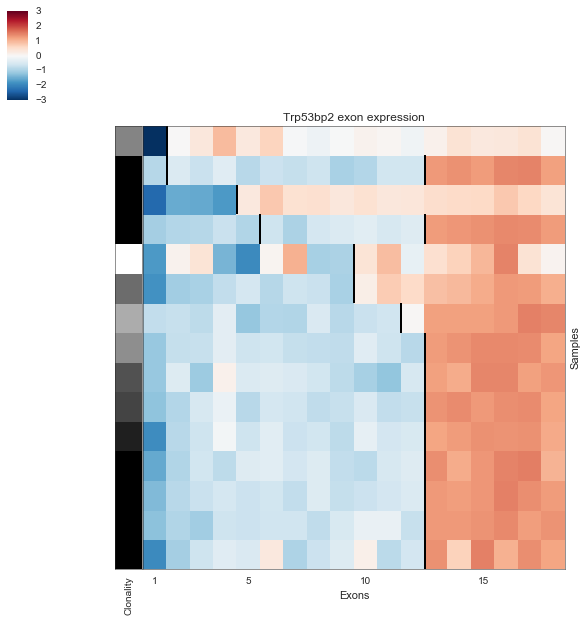

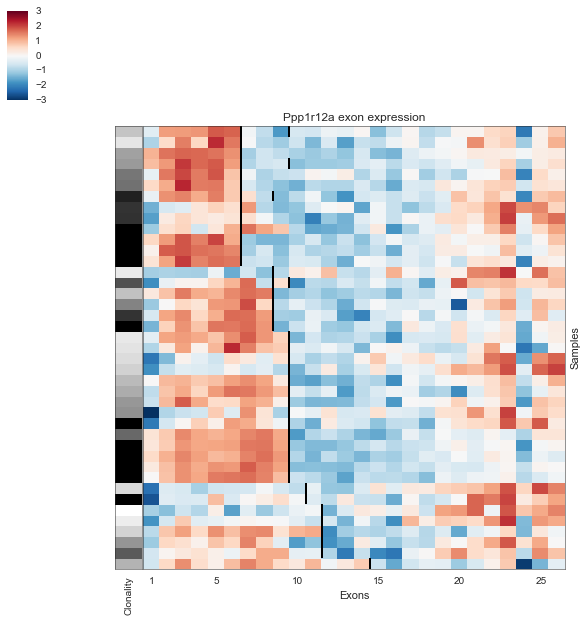

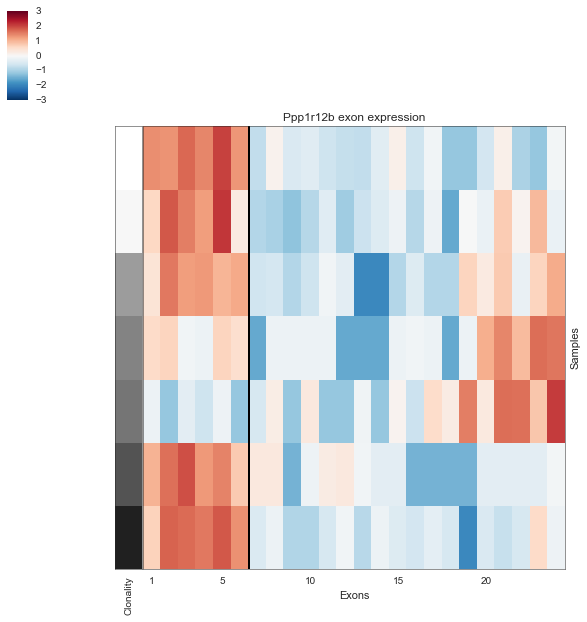

In [153]:
from nbsupport.insertions import plot_exon_expression

shared_kws = {
    'vmax': 3,
    'vmin': -3,
    'insertions': insertions,
    'z_score': 1
}

plot_exon_expression(coverage, gene='Trp53bp2', **shared_kws)
plot_exon_expression(coverage, gene='Ppp1r12a', **shared_kws)
plot_exon_expression(coverage, gene='Ppp1r12b', **shared_kws)

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_exon_expression(coverage, gene='Ppp1r12b', 
                              figsize=(4, 1.28), **shared_kws)
    cm.savefig('../reports/figures/fig_5_ppp1r12b_expr.pdf', bbox_inches='tight')
    plt.close(cm.fig)

    cm = plot_exon_expression(coverage, gene='Ppp1r12a',
                              figsize=(4, 2.6), **shared_kws)
    cm.savefig('../reports/figures/fig_5_ppp1r12a_expr.pdf', bbox_inches='tight')
    plt.close(cm.fig)

    cm = plot_exon_expression(coverage, gene='Trp53bp2',
                              figsize=(4, 1.45), **shared_kws)
    cm.savefig('../reports/figures/fig_5_trp53bp2_expr.pdf', bbox_inches='tight')
    plt.close(cm.fig)

This heatmaps show a relative increase in expression of the N-terminal part of *Ppp1r12a/b* and the C-terminal part of *Trp53bp2* compared to the full length transcripts, further supporting the hypothesis that these insertions result in the expression of truncated transcripts.